# Tracking growth of shoots across time series in a fully automated pipeline for high throughput phenotyping

In this notebook we will demonstrate the steps of the pipeline used to extract the individual shoots and track their growth across an image time series.
Bellow is a summary of the steps:

1. Load the image time series and reduce resolution of images (in order to make processing faster)
1. Segment out shoots from images (semantic segmentation with DL)
1. Identify circle (which is the pot rim) using Hough Circles algorithm
1. Ensure that the segmentation and image of the identified pot rim are of the same dimensions
1. Post-process the segmentated shoots to ensure they are mostly continuous (dilution/opening/skeletonization)
1. Algorithm to track whether or not a shoot belongs to a pot
    1. If the end of the elongated polygon is within N pixels of the pot rim identify as an individual belonging to the pot
1. Divide into sectors and associate each individual that starts within a sector as a unique individual belonging to the pot

In [1]:
import sys
sys.path.append('../')  # make parent directory available for the session

In [2]:
from utils.image_utils import load_image_ts, reduce_resolution, white_balance
from utils.skeleton_utils import get_endpoints, get_branching_points
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from PIL import Image
from utils.torch_datasets.niab import IMG_TRANSFORMS
from skimage.morphology import skeletonize
from scipy.ndimage import label, generate_binary_structure
from scipy.ndimage import convolve

/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load and pre-process images

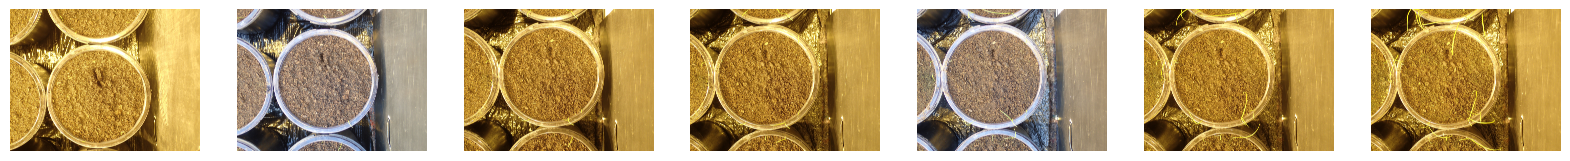

In [4]:
# Load image time series and plot
raw_images = load_image_ts(dataset_root = "../datasets/niab",
                       exp = 1,
                       block = 1,
                       pot = 1)

fig, ax = plt.subplots(1, len(raw_images), figsize=(20, 20))
for i, image in enumerate(raw_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

In [5]:
# Reduce resolution of images to 10% of the original size to speed up processing (notably segmentation and circle detection)
small_images = [reduce_resolution(image, 10) for image in raw_images]

print("Original image size: ", raw_images[0].shape)
print("Reduced image size: ", small_images[0].shape)

Original image size:  (3456, 4608, 3)
Reduced image size:  (345, 460, 3)


## Step 2: Shoot segmentation

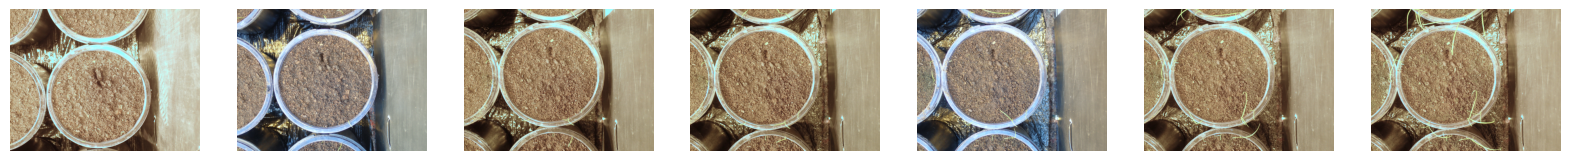

In [6]:
# White balance images to make them more similar across the time series and display
wb_small_images = [white_balance(image) for image in small_images]

fig, ax = plt.subplots(1, len(wb_small_images), figsize=(20, 20))
for i, image in enumerate(wb_small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

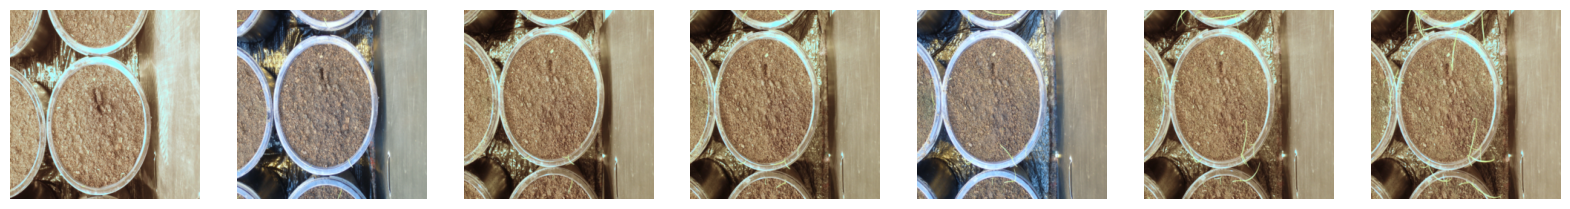

In [7]:
# Transform images for input to the shoot segmentation model
transformed_wb_small_images = [IMG_TRANSFORMS(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))) for image in wb_small_images]

# display the transformed images
fig, ax = plt.subplots(1, len(transformed_wb_small_images), figsize=(20, 20))
for i, image in enumerate(transformed_wb_small_images):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis('off')

Running model using cuda device


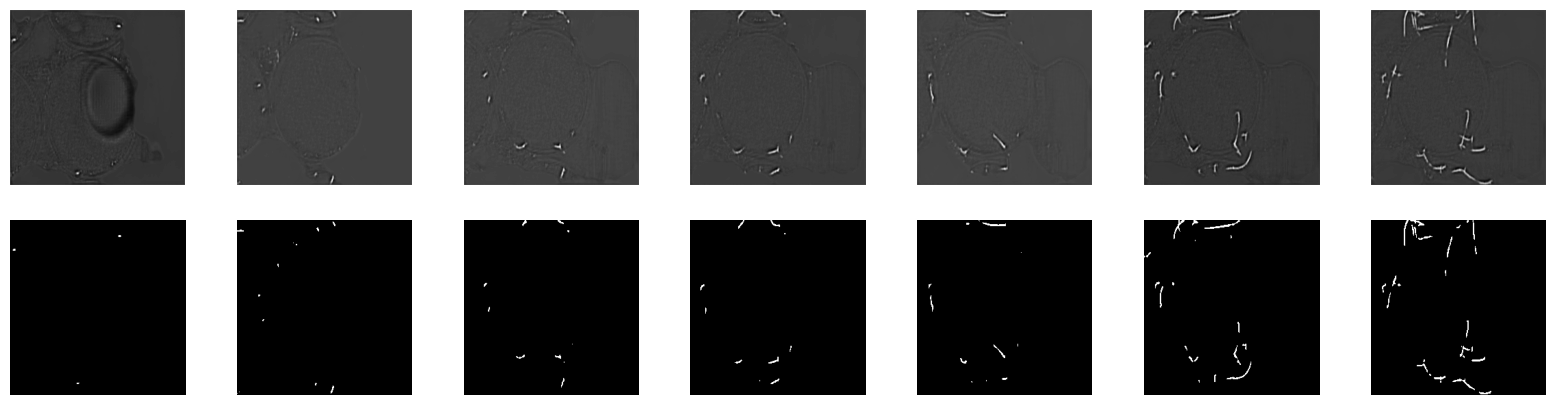

In [8]:
MODEL_PATH = "../models/best_model_unet_26_04.pth"
THRESHOLD = 0.7

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running model using {device} device")

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Inference on the transformed images
predictions = [model(image.unsqueeze(0).to(device)) for image in transformed_wb_small_images]

# Generate binary predictions from the model output
binary_predictions = [prediction.squeeze(0).squeeze(0) > THRESHOLD for prediction in predictions]

# Display predictions and binary predictions
fig, ax = plt.subplots(2, len(predictions), figsize=(20, 5))
for i, (prediction, binary_prediction) in enumerate(zip(predictions, binary_predictions)):
    ax[0, i].imshow(prediction.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(binary_prediction.cpu().detach().numpy(), cmap='gray')
    ax[1, i].axis('off')

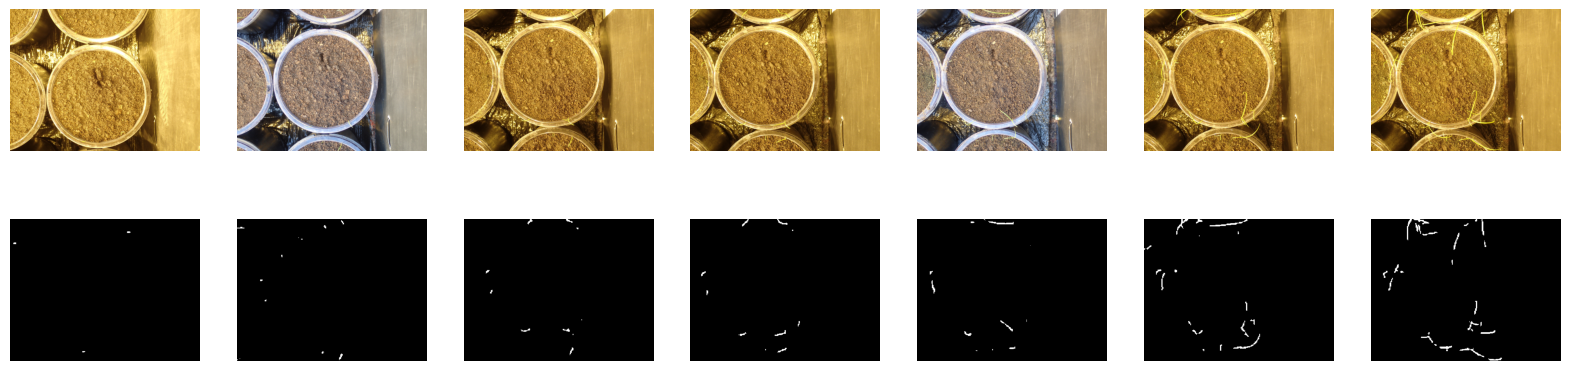

In [9]:
# Resize the predictions so that they match with the small images
resized_predictions = [cv2.resize(prediction.cpu().numpy().astype(np.uint8), (small_images[0].shape[1], small_images[0].shape[0]), interpolation=cv2.INTER_NEAREST) for prediction in binary_predictions]

# plot the images (row 1 ) and the predictions (row 2)
fig, ax = plt.subplots(2, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0, i].axis('off')
    ax[1, i].imshow(resized_predictions[i], cmap='gray')
    ax[1, i].axis('off')

## Step 3: Identifying pot rims

[((212, 214), 124), ((214, 176), 126), ((208, 160), 126), ((186, 168), 129), ((184, 164), 126), ((194, 166), 123), ((190, 162), 131)]


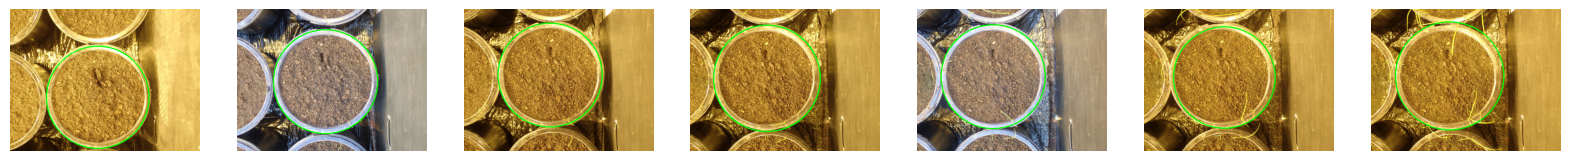

In [10]:
# Convert the images to greyscale for circle detection
grey_small_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in small_images]

saved_circles = []  # [((x, y), r)...]

# Detect circles in each greyscale image
for i, img in enumerate(grey_small_images):
    # Use HoughCircles to detect circles in the image
    # Parameters have been tuned to detect the pot rim in the images (might need to be adjusted for other images)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100, param1=50, param2=30, minRadius=120, maxRadius=135)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            saved_circles.append((center, radius))
            cv2.circle(small_images[i], center, radius, (0, 255, 0), 2)

print(saved_circles)

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 20))
for i, image in enumerate(small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

## Step 4: Shoot identification

### Step 4 (a): Identify shoots belonging to pot

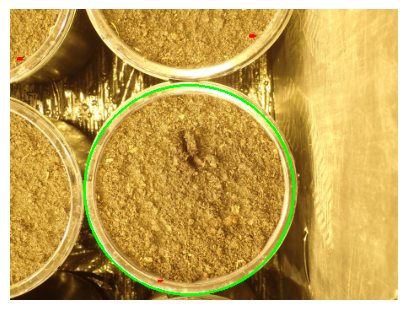

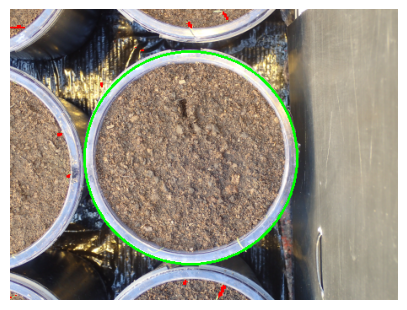

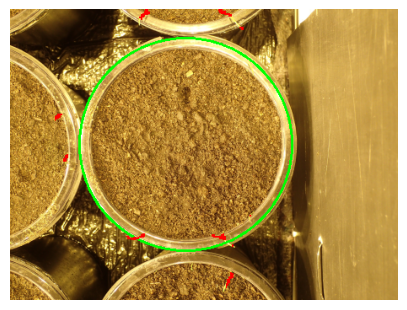

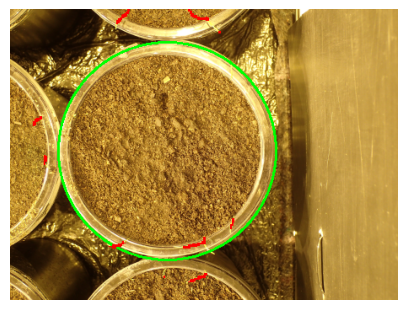

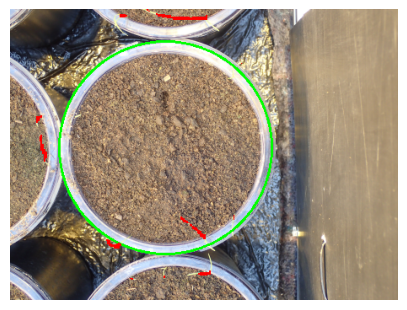

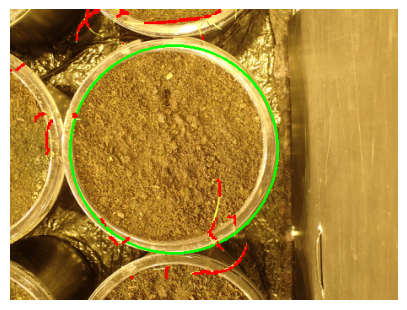

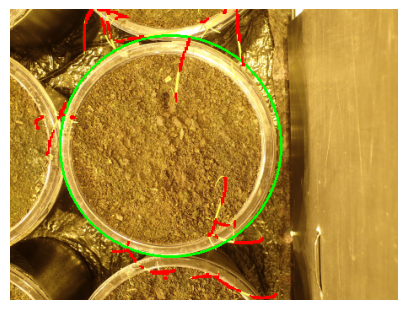

In [11]:
# Overlay the circle on the predictions
for i, (img, prediction) in enumerate(zip(small_images, resized_predictions)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img[prediction == 1] = [255, 0, 0]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    ax.axis('off')

    plt.show()

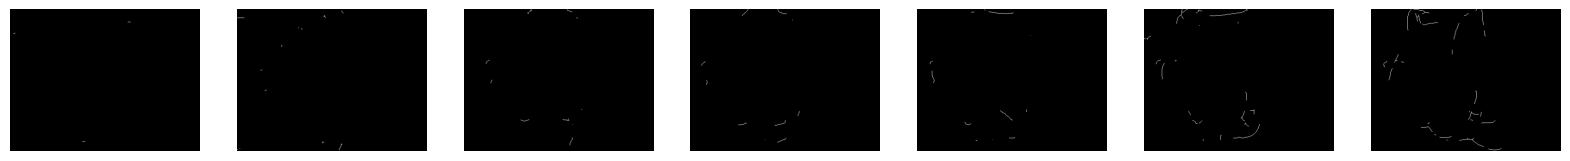

In [16]:
# TODO: probably will want to do some post-processing here to improve mask (opening/dilution)

# Skeletonize the binary predictions masks to run logic on the geometry of the shoots and the pot rim
skeletonised_masks = [skeletonize(prediction) for prediction in resized_predictions]

# plot the skeletonised mask
fig, ax = plt.subplots(1, len(skeletonised_masks), figsize=(20, 20))
for i, skeleton in enumerate(skeletonised_masks):
    ax[i].imshow(skeleton, cmap='gray')
    ax[i].axis('off')

Number of labels: 12
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False
Is in circle: False


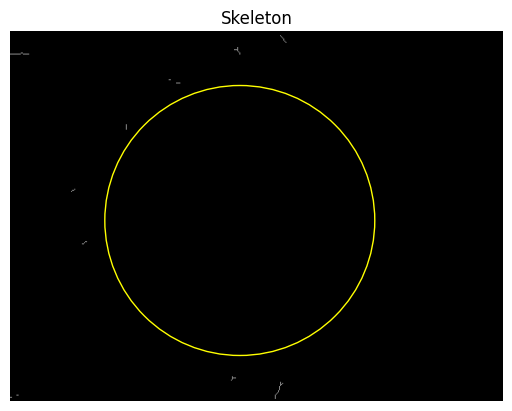

In [29]:
# TODO : extend this to all skeletonised masks in ts

skeleton_nb = 1

circle_coords = saved_circles[skeleton_nb]  # ((x, y), r)

# Create a structuring element for 8-connectivity
s = generate_binary_structure(2,2)

# The label function from scipy.ndimage uses 4-connectivity by default
# Assuming `skeleton` is your skeletonized image
labeled_skeletons, num_labels = label(skeletonised_masks[skeleton_nb], structure=s)

print(f"Number of labels: {num_labels}")

# new image of the same shape as skeleton where only the labeled_skeletons that 
# meet the is_in_circle condition are added
new_image = np.zeros_like(skeletonised_masks[skeleton_nb]).astype(np.uint8)

for skeleton in range(1, num_labels + 1):

    # Create a new image where the random label is highlighted
    highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

    end_points = get_endpoints(highlighted)

    is_in_circle = False
    for point in end_points:
        in_circle = ((point[0] - circle_coords[0][1])**2 + (point[1] - circle_coords[0][0])**2) <= circle_coords[1]**2
        if in_circle:
            print(f"End point {point} is within the circle")
            is_in_circle = True
            break

    print(f"Is in circle: {is_in_circle}")

    if is_in_circle:
        new_image += highlighted.astype(np.uint8)


plt.imshow(skeletonised_masks[skeleton_nb], cmap='gray')
plt.title('Skeleton')
plt.axis('off')

# Display the circle
circle = plt.Circle(circle_coords[0], circle_coords[1], color='yellow', fill=False)
plt.gca().add_artist(circle)

# Overlay the new image on the skeleton
plt.imshow(new_image, cmap='gray', alpha=0.5)

# # if at least 1 endpoint is within the circle, then we have to assume that the shoot is part of the pot
# # This could later be improved to: if an endpoint with within a certain distance of the circle, then the shoot is part of the pot as we know that the seeds were planted along the rim of the pot

Number of skeletons (continuous shoots) in image: 3
Number of skeletons (continuous shoots) in image: 12
Number of skeletons (continuous shoots) in image: 10
Number of skeletons (continuous shoots) in image: 10
Number of skeletons (continuous shoots) in image: 12
Number of skeletons (continuous shoots) in image: 20
Number of skeletons (continuous shoots) in image: 27
Number of skeletons (continuous shoots) in pot 0
Number of skeletons (continuous shoots) in pot 5
Number of skeletons (continuous shoots) in pot 4
Number of skeletons (continuous shoots) in pot 3
Number of skeletons (continuous shoots) in pot 3
Number of skeletons (continuous shoots) in pot 7
Number of skeletons (continuous shoots) in pot 10


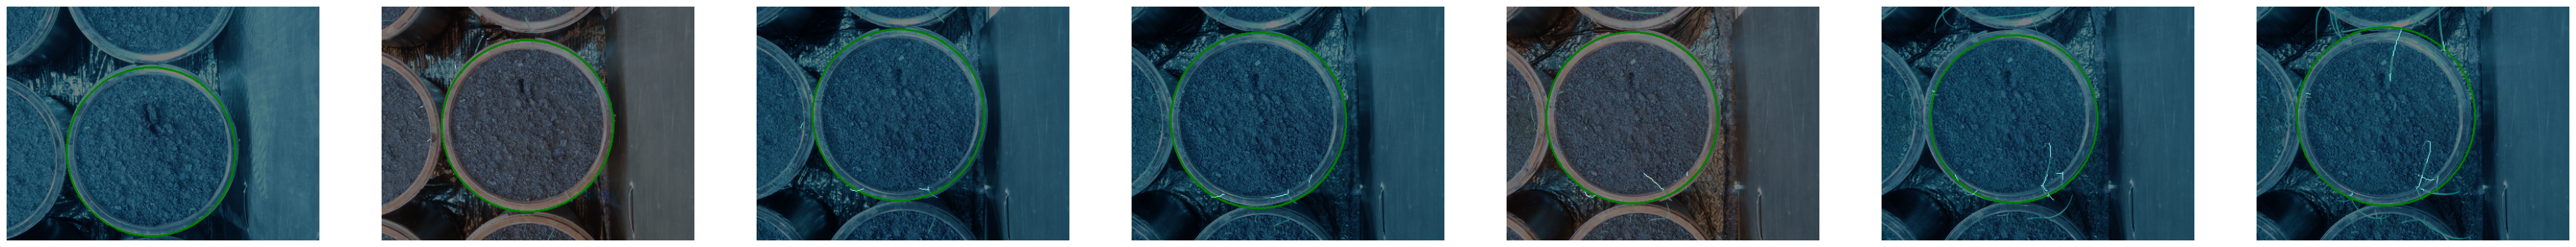

In [26]:
# for each skeleton
# for each label in the skeleton
# check if the label has an endpoint within the circle
# if it does, then the shoot is part of the pot add it to the list of shoots

# TODO: weird bug e.g. image 1 (second image) seems to be counting shoots as within the circle when they are not
# Odd because it is not classified as in circle in the previous cell

skeleton_ts = []

for skeleton_nb in range(len(skeletonised_masks)):
    labeled_skeletons, num_labels = label(skeletonised_masks[skeleton_nb], structure=s)

    print(f"Number of skeletons (continuous shoots) in image: {num_labels}")

    skeletons = []
    for skeleton in range(1, num_labels + 1):
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        end_points = get_endpoints(highlighted)

        is_in_circle = False
        for point in end_points:
            in_circle = ((point[0] - circle_coords[0][1])**2 + (point[1] - circle_coords[0][0])**2) <= circle_coords[1]**2
            if in_circle:
                # print(f"End point {point} is within the circle")
                is_in_circle = True
                break

        if is_in_circle:
            skeletons.append(highlighted)

    skeleton_ts.append(skeletons)


skeletons_in_pot = []

fig, ax = plt.subplots(1, len(skeleton_ts), figsize=(50, 50))
for i, filtered_skeleton in enumerate(skeleton_ts):
    print(f"Number of skeletons (continuous shoots) in pot {len(filtered_skeleton)}")

    # filtered_skeletons is a list of binary images with a single labeled shoot per image
    # produce a combined image of all the filtered shoots for visualisation
    if len(filtered_skeleton) == 0:
        # create a blank image (no shoots in pot)
        combined_image = np.zeros_like(skeletonised_masks[0])
    else:
        combined_image = np.zeros_like(skeletonised_masks[0])
        for skeleton in filtered_skeleton:
            # Add the skeleton to the combined image i.e. where the skeleton is 1, set the pixel to 1
            combined_image = np.logical_or(combined_image, skeleton)

    skeletons_in_pot.append(combined_image)

    ax[i].imshow(combined_image, cmap='gray')
    # disply the resised image
    ax[i].imshow(small_images[i], alpha=0.5)
    ax[i].axis('off')

plt.show()

### Step 4 (b): Identifying individual within pot

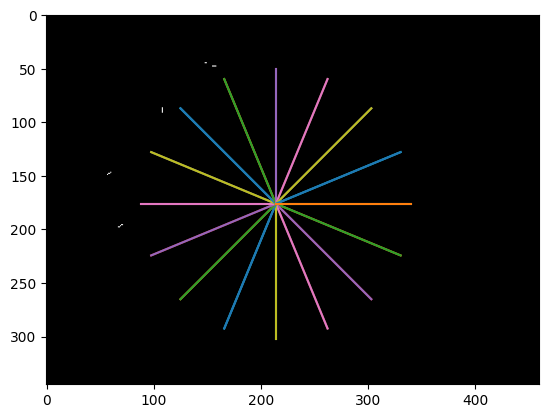

Pot 0
Pot 1
[-1 -1]
[-1 -1]
[-1 -1]
[-1 -1]
[-1 -1]
Pot 2
[-1 -1]
[1 1]
[1 0 1]
[-1 -1]
Pot 3
[1 1]
[1 0]
[-1 -1]
Pot 4
[2 1]
[0 1]
[-1 -1]
Pot 5
[-1 -1]
[2 1]
[1 1 1]
[-1 -1]
[1 0 1]
[-1 -1]
[1 1 1]
Pot 6
[7 7]
[6 6]
[7 7]
[-1 -1]
[2 1]
[1 1]
[1 1 1]
[1 1]
[1 1]
[-1 -1]


In [31]:
# TODO: Have another round of filtering based on whether or not the individual lies within a sector of the pot

# like how we can select the exp, block and pot number, we can also select the sector number (individual) and then produce development metrics for that individual

import matplotlib.patches as patches

def draw_sectors(image, center, radius, num_sectors):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image, cmap='gray')  # Display the image

    # Calculate the angle for each sector
    angles = np.linspace(0, 2 * np.pi, num_sectors + 1)

    for i in range(num_sectors):
        # Calculate the end points of the sector
        x = center[0] + radius * np.cos(angles[i:i+2])
        y = center[1] + radius * np.sin(angles[i:i+2])

        # Draw the sector
        sector = patches.Polygon(np.column_stack([x, y]), closed=True, fill=False)
        ax.add_patch(sector)

        # add lines joining the center to the sector
        ax.plot([center[0], x[0]], [center[1], y[0]])
        ax.plot([center[0], x[1]], [center[1], y[1]])

    plt.show()

img_of_interest = 1

# Assuming 'image' is your image data
draw_sectors(skeletons_in_pot[img_of_interest], saved_circles[img_of_interest][0], saved_circles[img_of_interest][1], 16)

def get_sector(skeleton, center, num_sectors):
    # get endoints of the skeleton
    end_points = get_endpoints(skeleton)

    # Calculate the angle for each sector
    angles = np.linspace(0, 2 * np.pi, num_sectors + 1)

    # Calculate the angle of each endpoint relative to the center
    angles_endpoints = np.arctan2(end_points[:, 1] - center[0], end_points[:, 0] - center[1])

    # Calculate the sector for each endpoint
    sectors = np.digitize(angles_endpoints, angles) - 1

    return sectors

for i, skeletons in enumerate(skeleton_ts):
    print(f"Pot {i}")
    for skeleton in skeletons:
        # what sector is the shoot in?
        sector = get_sector(skeleton, saved_circles[i][0], 16)
        print(sector)

## Step 5: Tracking development

In [ ]:
# Plot the growth of each individual belonging to a sector of the pot over time